# 1. 감정분류_BERT

## (1) import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
import random
import time

# 전처리
from sklearn.preprocessing import LabelEncoder

# 학습
from sklearn.model_selection import train_test_split

import tensorflow as tf

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

import keras
from keras.utils import pad_sequences

## (2) 데이터 확인

In [3]:
# folder_path = ''
folder_path = '/content/drive/MyDrive/고수의클래스_0906/2교시_자연어처리/data_folder'

In [4]:
train = pd.read_csv(folder_path + '/corpus2_train.csv', encoding='UTF-8')
test = pd.read_csv(folder_path + '/corpus2_test100.csv', encoding='UTF-8')

In [5]:
display(train.head())
display(test.head())

,감정,문장
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


,문장
0,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.
1,무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?
2,먹고 살기 위해 남편이 아직 일하고 있지만 나는 능력이 안 돼서 짜증이 나.
3,실수해서 해고를 당했어. 당장 경제적으로 힘든데 좀 더 잘하지 못해 죄책감이 들어.
4,나이가 들수록 점점 사람 자체를 믿지 못하겠어. 남편도 마찬가지야.


In [6]:
## 선택: 컬럼명 변경 ##
train = train.rename(columns={'감정': 'label', '문장': 'text'})
test = test.rename(columns={'감정': 'label', '문장': 'text'})

In [7]:
display(train.head(1))
display(test.head(1))

,label,text
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.


,text
0,남편과 사별한 후 아무 일도 손에 잡히지 않아. 아이들도 있는데 왜 이러는지 모르겠어.


## (3) 데이터 전처리

### 1. 레이블링 ( 문자 -> 숫자로 인코딩 )

In [8]:
encoder = LabelEncoder()
train['label'] = encoder.fit_transform(train['label'])
# 라벨이 정답이라, test 데이터에는 없음 -> train 데이터만 fit_transform

### 2. 중복제거

In [9]:
# text 열 중복 제거
train.drop_duplicates(subset=['text'], inplace=True)
test.drop_duplicates(subset=['text'], inplace=True)

### 3. 특수문자 제거 ( 정규표현식 )

In [10]:
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]", "")

### 4. Null 값 제거

In [11]:
# 하나라도 결측값이 있는 행 또는 열 제거
train = train.dropna(how='any')
test = test.dropna(how='any')

## (4) 학습

In [12]:
# 훈련 데이터 비율 지정
rate = 0.8

### 1. BERT 형식으로 변환 ( [CLS] 문장 [SEP] )

In [13]:
# 시작과 끝에 특수 토큰을 추가하여 문장의 시작과 끝을 알림

sentences = train['text']

sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

# 라벨 추출 ( test 데이터에는 없음 )
labels = train['label'].values

### 2, BERT로 토큰화하기

In [14]:
bert_model = "bert-base-multilingual-cased"

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 3. 문장 길이 조회

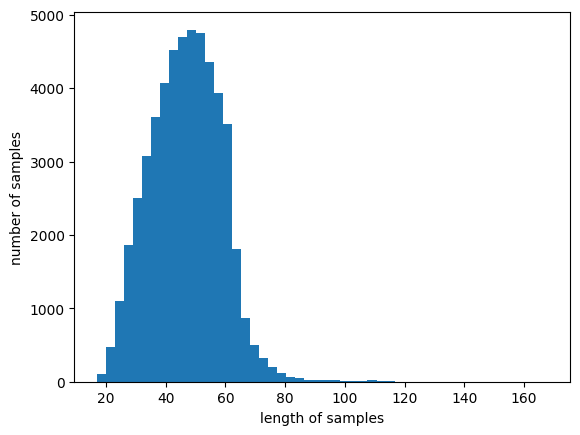

In [15]:
# 문장 길이 전체 그래프로 문장의 전체 분포 파악 가능
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 길이가 n 이하인 데이터의 비율 계산 함수
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s) <= max_len:
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (cnt / len(nested_list)) * 100))

max_len = 60
below_threshold_len(max_len, sentences) # 이 함수 보고 max_len 설정

전체 샘플 중 길이가 60 이하인 샘플의 비율: 87.53422263645366


### 4. 토큰 인덱스 변환, 패딩 및 어텐션 마스크 세팅

In [17]:
# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 max_len 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [18]:
print(input_ids[0])
print(attention_masks[0])

[   101   9641  10892   9596   9960  12092   9960  12092   8977  10739
   9555  10622 118671    136   9993  11287   8984  11903    119    102
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 5. 훈련데이터와 검증데이터 분리 및 배치 세팅

In [19]:
batch_size = 64

# 훈련셋과 검증셋으로 분리
validation_size = 0.2

random_state = 1

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=random_state,
                                                                                    test_size=0.1)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=random_state,
                                                       test_size=0.1)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
print("##### 훈련 텍스트의 bert embedding값 #####")
print(train_inputs[0])
print("##### 훈련 텍스트의 label 값 #####")
print(train_labels[0])
print("##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(train_masks[0])
print("##### 검증 텍스트의 bert embedding값 #####")
print(validation_inputs[0])
print("##### 검증 텍스트의 label 값 #####")
print(validation_labels[0])
print("##### 검증 텍스트의 MASK값 = 패딩 여부 확인 #####")
print(validation_masks[0])

##### 훈련 텍스트의 bert embedding값 #####
tensor([  101,  9288, 10739,  9521,  9685, 16985,   119,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
##### 훈련 텍스트의 label 값 #####
tensor(3)
##### 훈련 텍스트의 MASK값 = 패딩 여부 확인 #####
tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
##### 검증 텍스트의 bert embedding값 #####
tensor([   101,  66402,   9694,  80331,  20729,   9434,  14801,  10739,  62548,
          9141,  65164,  12424,

### 6. GPU 세팅
- Colab에서만 진행해야 할 지, 시험환경에서도 진행해야 할 지 의문

In [21]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print("Found GPU at: {}".format(device_name))
else:
    raise SystemError("GPU device not found")

# 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


#### 7. 딥러닝 모델 세팅

In [22]:
# 분류를 위한 BERT 모델 생성

# 분류개수 ( 변동 가능 )
classification_count = 6

# 반복 횟수 ( 변동 가능 )
epochs = 3

model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=classification_count)
model.cuda()

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr=2e-5, # 학습률
                  eps=1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 총 훈련 스탭 : 배치반복 횟수 * 에폭수
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### 8. 딥러닝 모델 간략하게 보기

In [24]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

#### 9. 딥러닝 학습

In [36]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed))) # elapsed에 왜 괄호를 한 번 더 하는지.. 의문.. 안 되면 빼고 해보기

    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 학습
## 현재 150000개의 데이터로는 1 epoch 50분 정도의 시간이 소요됩니다.
## 4번의 epoch이기에 약 200분, 3시간이 넘는 학습 시간이 필요합니다. -> 3번으로 줄이신 듯
## 연습을 하실 때에는 1000개 정도로 데이터량을 줄여서 테스트 해보실 것을 권장드립니다.

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    print("")
    print("======= Epoch {:} / {:} =======".format(epoch_i + 1, epochs))
    print("Training...")

    t0 = time.time()

    total_train_loss = 0

    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시 / 매 40 배치마다
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 초기화
        model.zero_grad()

        output = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels)

        # 총 로스 계산
        loss = output[0]
        total_train_loss += loss.item()
        logits = output[1]

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산 안 함
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)

        # 로스 구함
        loss = output.loss
        total_eval_loss += loss.item()
        logits = output.logits

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training. Accur': avg_val_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======= Epoch 1 / 3 =======
Training...


KeyboardInterrupt: 

#### 10. 딥러닝 학습 간단 보기

       Training Loss  Valid. Loss  Training. Accur  Valid. Accur. Training Time Validation Time
epoch                                                                                          
1           1.361350     1.210654         0.538537       0.538537       0:07:31         0:00:17
2           1.170938     1.173099         0.551654       0.551654       0:07:32         0:00:17
3           1.099437     1.170897         0.549352       0.549352       0:07:32         0:00:17


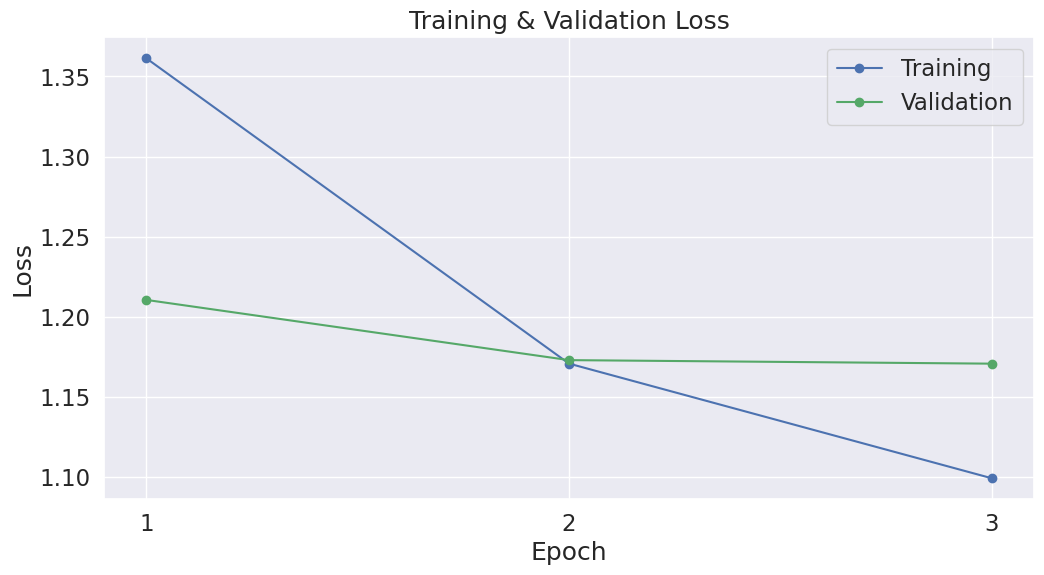

In [26]:
pd.set_option('display.max_columns', 100)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

print(df_stats.to_string())

sns.set(style="darkgrid")

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1, epochs + 1)])

plt.show()

## (5) 결과 제출

In [37]:
temp_sentence = '무릎이 아파서 잠시 걷는 것조차 힘들어졌어. 내가 앞으로 무얼 할 수 있을까?'

# 입력 데이터 변환 함수
def convert_input_data(sentences):
    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

logits = test_sentences([temp_sentence])

print(logits)
print(np.argmax(logits))
print(encoder.inverse_transform([np.argmax(logits)])[0])
print(encoder.inverse_transform([5])[0])

[[-3.1206148  -0.0761313   0.9588022   0.89858663  0.75236386  0.55931365]]
2
분노
슬픔


In [38]:
# 테스트 데이터를 for문으로 test_sentences 함수에 하나씩 넣어 감정 분류 해주고,
# 숫자로 되어 있는 것을 다시 디코딩 작업하여 답안지 생성.
result = []
x_test = test['text']

for item in x_test:
    logits = test_sentences([item])
    pred = np.argmax(logits)
    pred = encoder.inverse_transform([pred])[0]
    result.append(pred)

print(result)

['분노', '분노', '분노', '당황', '상처', '슬픔', '불안', '슬픔', '분노', '불안', '불안', '슬픔', '불안', '상처', '불안', '슬픔', '상처', '슬픔', '불안', '불안', '불안', '불안', '상처', '상처', '분노', '당황', '슬픔', '당황', '분노', '불안', '상처', '상처', '당황', '불안', '불안', '슬픔', '분노', '슬픔', '분노', '상처', '상처', '상처', '당황', '슬픔', '불안', '불안', '당황', '분노', '상처', '당황', '분노', '당황', '당황', '불안', '분노', '분노', '불안', '슬픔', '분노', '상처', '상처', '상처', '슬픔', '상처', '당황', '상처', '불안', '분노', '상처', '분노', '당황', '불안', '상처', '상처', '상처', '슬픔', '상처', '상처', '당황', '상처', '당황', '상처', '상처', '상처', '불안', '상처', '불안', '불안', '당황', '불안', '슬픔', '슬픔', '불안', '당황', '상처', '상처', '분노', '불안', '상처', '상처']


In [39]:
test['result'] = result

In [40]:
test.to_csv('01073002902_2.csv', index=False)
torch.save(model, "01073002902_2.h5")